In [7]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [8]:
chk = pd.read_csv('../genetic_algorithm/chk.csv')
mols = pd.read_csv('../genetic_algorithm/test.csv')

In [9]:
chk.columns = ['name', 'score']
chk.head()

,name,score
0,1_3_248,-11.400000
1,4_3_330,-10.666667
2,5_6_46,-9.833333
3,5_4_221,-12.066667
4,4_0_186,-11.166667


In [10]:
mols.head()

,name,smiles
0,0_0_0,O=C(CCCC[C@@H]1CCSS1)NCCCCCCNC(=O)c1ccc(-c2c3n...
1,0_0_1,O=C(NCCCCCCNC(=O)c1ccc(-c2c3nc(c(-c4c(F)c(F)c(...
2,0_0_2,Nc1c(CC(=O)NCCCCCCNC(=O)c2ccc(-c3c4nc(c(-c5c(F...
3,0_0_3,CC(C)(C)c1cc2c(cc1Cl)C=C(C(=O)NCCCCCCNC(=O)c1c...
4,0_0_4,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)NCCCCCCNC(=O)c1cc...


In [11]:
merged = pd.merge(chk, mols, on='name', how='left')

In [12]:
merged.head()

,name,score,smiles
0,1_3_248,-11.400000,COc1ccc(-c2ccc(CCC(=O)OCCOC(=O)c3ccc(-c4c5nc(c...
1,1_3_248,-11.400000,COc1ccc(-c2ccc(CCC(=O)OCCOC(=O)c3ccc(-c4c5nc(c...
2,4_3_330,-10.666667,CCCCCCNC(=O)Oc1cccc(-c2ccc(C(C)C(=O)OCCOC(=O)c...
3,5_6_46,-9.833333,Cc1cc(Br)cc2c1OC(C(F)(F)F)C(C(=O)OCCOCCOCCOCCO...
4,5_6_46,-9.833333,Cc1cc(Br)cc2c1OC(C(F)(F)F)C(C(=O)OCCOCCOCCOCCO...


In [13]:
merged.shape

(13897, 3)

In [14]:
merged.drop_duplicates(inplace=True)

In [15]:
merged.head()

,name,score,smiles
0,1_3_248,-11.400000,COc1ccc(-c2ccc(CCC(=O)OCCOC(=O)c3ccc(-c4c5nc(c...
2,4_3_330,-10.666667,CCCCCCNC(=O)Oc1cccc(-c2ccc(C(C)C(=O)OCCOC(=O)c...
3,5_6_46,-9.833333,Cc1cc(Br)cc2c1OC(C(F)(F)F)C(C(=O)OCCOCCOCCOCCO...
5,5_4_221,-12.066667,Cc1cc2c(c(C)c1Cl)C=C(C(=O)OCCOCCOC(=O)c1ccc(-c...
6,4_0_186,-11.166667,Cc1cccc(Nc2ccccc2C(=O)NCCCCCCNC(=O)c2ccc(-c3c4...


In [16]:
def could_be_mol(smiles):
    try:
        Chem.MolFromSmiles(smiles)
        return True
    except:
        return False

In [17]:
merged['could_be_mol'] = merged['smiles'].apply(could_be_mol)

In [18]:
merged.could_be_mol.value_counts()

True     13121
False      337
Name: could_be_mol, dtype: int64

In [19]:
merged = merged[merged.could_be_mol]

In [20]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [21]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [22]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [23]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    print(mol_sentence)
    mol2vec = DfVec(sentences2vec(mol_sentence, model, unseen='UNK'))
    return mol2vec.vec

In [24]:
import time
CALLS = []
target = merged.score.values
def get_score(id):
    global CALLS
    CALLS.append(id)
    return target[id]

In [25]:
from sklearn.neighbors import NearestNeighbors
import torch
import warnings
class ChemicalSpace:
    def __init__(self, file):
        if file.split('.')[-1] == 'csv':
            compounds = pd.read_csv(file, delimiter = ",")
        elif file.split('.')[-1] == 'smi':
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.compounds = compounds
        self.compounds['mol'] = self.compounds['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
        self.compounds['mol_sentence'] = self.compounds.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
        self.mol2vec = [DfVec(x) for x in sentences2vec(self.compounds['mol_sentence'], model, unseen='UNK')]
        self.mol2vec = np.array([x.vec for x in self.mol2vec])
        split = {f'vec_{i}': self.mol2vec[:, i] for i in range(self.mol2vec.shape[1])}
        self.vecs = pd.DataFrame(split)
        self.scores_cache = {}
        self.iter_neighbors = []
    def init_knn(self, n_neighbors=5):
        self.nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(self.mol2vec)
    def get_neighbors(self, vec, return_distance=False):
        if len(vec.shape) == 1:
            vec = vec.reshape(1, -1)
        return self.nbrs.kneighbors(vec, return_distance=return_distance)
    def set_objective(self, objective, **kwargs):
        # objective is a function that takes in an id and returns a score
        self.objective = objective
        self.objective_kwargs = kwargs
    def get_objective(self, id):
        if id not in self.scores_cache:
            self.scores_cache[id] = self.objective(id, **self.objective_kwargs)
        return self.scores_cache[id]
    def reset_neighbors(self):
        self.iter_neighbors = []
    def add_step_neighbors(self, neighbors):
        self.iter_neighbors.append(neighbors)
    def f(self, X):
        if not isinstance(X, torch.Tensor):
            warnings.warn("X is not a torch tensor. Converting to torch tensor...")
            X = torch.tensor(X, dtype=torch.float, requires_grad=True)
        X_numpy = X.detach().numpy()
        # get neighbors
        neighbors = self.get_neighbors(X_numpy)[0]
        # add neighbors to list of neighbors
        self.add_step_neighbors(neighbors)
        # get scores of neighbors
        scores = torch.tensor([self.get_objective(i) for i in neighbors], dtype=torch.float64, requires_grad=True)
        # get coordinates of neighbors
        coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float64, requires_grad=True)
        # f(x) = distance weighted average of neighbors
        # distance weighted average = sum of scores * (1 / distance)
        distance_sum = torch.sum(1 / torch.sqrt(torch.sum((coords - X)**2, axis=1)), dtype=torch.float64)
        scores = torch.sum(scores * (1 / torch.sqrt(torch.sum((coords - X)**2, axis=1))), dtype=torch.float64) / distance_sum
        return torch.mean(scores)

In [26]:
merged.to_csv('history.csv')
smi = 'history.csv'

In [27]:
space = ChemicalSpace(smi)

In [28]:
space.mol2vec[0]

array([ 8.74383450e+00, -1.16018171e+01, -1.64639606e+01,  2.49030704e+01,
       -4.36659193e+00, -2.88725400e+00, -3.82130928e+01, -9.44645226e-01,
        2.78874588e+01,  1.44985428e+01, -1.37672882e+01, -3.05505490e+00,
       -3.36061745e+01,  2.46499228e+00, -2.26407032e+01, -3.91858363e+00,
        1.39095078e+01, -1.38148193e+01, -1.34860544e+01,  2.49958038e+01,
        1.51091471e+01,  2.01385956e+01,  5.71145096e+01,  2.76117592e+01,
       -3.64472504e+01,  2.40855145e+00, -4.45863342e+00, -3.27441826e+01,
       -1.22627962e+00,  4.53340149e+00,  4.46113243e+01, -2.75367661e+01,
       -1.12057781e+01, -2.07878113e+01,  1.86894569e+01,  6.27529526e+00,
        6.13353109e+00, -4.18735266e+00,  3.14961910e+01,  6.25434399e+00,
       -9.40153694e+00, -2.65915489e+00, -1.38366556e+01,  1.26934290e+00,
       -4.35588570e+01,  1.95263195e+01, -6.62595928e-01,  3.02966557e+01,
       -2.12550201e+01,  1.83174229e+01,  1.97582321e+01, -2.16296597e+01,
       -9.72199821e+00, -

In [34]:
space.init_knn(n_neighbors=5)

In [35]:
space.get_neighbors(space.mol2vec[7])

array([[   7, 2732, 2665, 7142, 6284]])

In [36]:
space.get_neighbors(space.mol2vec[844])

array([[  844,  9731, 10285,  4006,   919]])

In [37]:
space.set_objective(get_score)

In [38]:
space.get_objective(84)

-11.466666666666669

In [39]:
%%time
space.get_objective(8)

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 21.5 µs


-12.5

In [40]:
%%time
space.get_objective(8)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


-12.5

In [41]:
debug_vector = torch.rand(300, requires_grad=True)

In [42]:
space.f(debug_vector)

/tmp/ipykernel_4492/1495248045.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673752754831/work/torch/csrc/utils/tensor_new.cpp:230.)
  coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float64, requires_grad=True)


tensor(-9.4587, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [43]:
from utils import *
global_seed(654)

Global seed set to 654


In [44]:
# optimize f(x)
X = torch.randn(300, requires_grad=True)

In [45]:
from torch.optim import Adam
optimizer = Adam([X], lr=10)

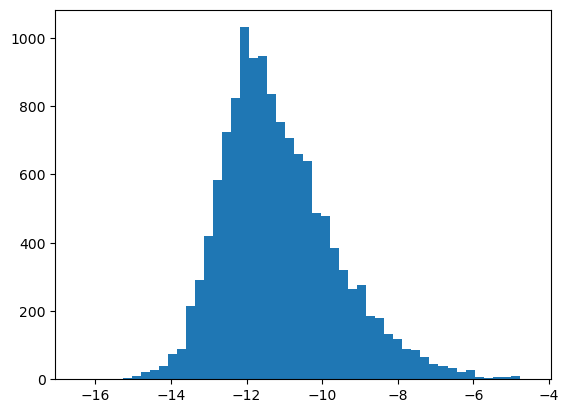

In [46]:
_ = plt.hist(target, bins=50)

In [47]:
CALLS = []
best = 0
for i in range(10000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    if loss.item() < best:
        best = loss.item()
    if i % 500 == 0:
        print(f'Iteration: {i}', f'Loss: {loss.item()}')

Iteration: 0 Loss: -9.45870264143334
Iteration: 500 Loss: -13.739992622755967
Iteration: 1000 Loss: -13.739999852112447
Iteration: 1500 Loss: -13.739999878223252
Iteration: 2000 Loss: -13.139999917774261
Iteration: 2500 Loss: -13.739999863350683
Iteration: 3000 Loss: -13.739999765687525
Iteration: 3500 Loss: -13.739999990938127
Iteration: 4000 Loss: -13.739999686912139
Iteration: 4500 Loss: -13.139999844886026
Iteration: 5000 Loss: -13.7399999250464
Iteration: 5500 Loss: -13.139998930875098
Iteration: 6000 Loss: -13.739999676311799
Iteration: 6500 Loss: -13.139999726017733
Iteration: 7000 Loss: -13.739999520844924
Iteration: 7500 Loss: -13.139999727157534
Iteration: 8000 Loss: -13.139999856368421
Iteration: 8500 Loss: -13.739999900925374
Iteration: 9000 Loss: -13.13999978006007
Iteration: 9500 Loss: -13.139999862530011


In [48]:
from scipy.stats import percentileofscore
# flatten list of lists
def unique_comps(iter_neighbors):
    return len(set([item for sublist in iter_neighbors for item in sublist]))
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')

Visited 70 unique compounds
Best score: -15.327756807255357
Percentile: 0.038106851611919824


In [57]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lrs_timeline = {lr: [] for lr in lrs}
exploration_index = []

In [58]:
for lr in lrs:
    space.reset_neighbors()
    print(f'Learning rate: {lr}')
    global_seed(676550)
    X = torch.randn(300, requires_grad=True)
    optimizer = Adam([X], lr=lr)
    CALLS = []
    for i in range(10000):
        optimizer.zero_grad()
        loss = space.f(X)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Iteration {i}: {loss.item()}')
            lrs_timeline[lr].append(loss.item())
    print(f'Visited {len(set(CALLS))} points')
    exploration_index.append(unique_comps(space.iter_neighbors))

Learning rate: 0.0001
Global seed set to 676550
Iteration 0: -9.458670308837206
Iteration 100: -9.458703268306284
Iteration 200: -9.458736228537639
Iteration 300: -9.458769190611342
Iteration 400: -9.458802154076837
Iteration 500: -9.458835118148036
Iteration 600: -9.458868082797833
Iteration 700: -9.458901049304153
Iteration 800: -9.458934016433076
Iteration 900: -9.458966983857595
Iteration 1000: -9.458999952864337
Iteration 1100: -9.459032923090202
Iteration 1200: -9.459065894622022
Iteration 1300: -9.459098866734315
Iteration 1400: -9.459131839574797
Iteration 1500: -9.459164812926577
Iteration 1600: -9.459197786935944
Iteration 1700: -9.459230761303418
Iteration 1800: -9.459263735930579
Iteration 1900: -9.459296710632005
Iteration 2000: -9.459329685810722
Iteration 2100: -9.459362660820382
Iteration 2200: -9.459395636142963
Iteration 2300: -9.459428610941645
Iteration 2400: -9.45946158557382
Iteration 2500: -9.459494559720184
Iteration 2600: -9.459527533101198
Iteration 2700: -9.4

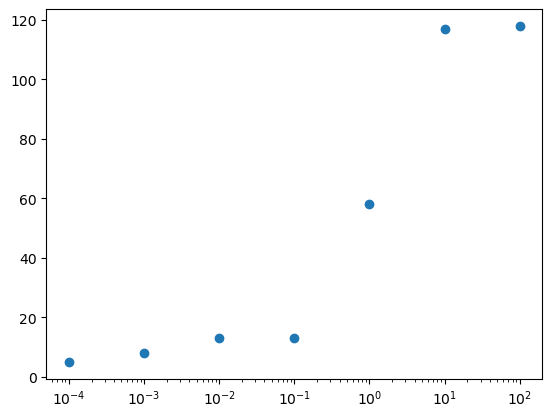

In [60]:
# plot learning rate vs exploration index plot in log scale
_ = plt.plot(lrs, exploration_index, 'o')
plt.xscale('log')

In [61]:
for lr in lrs:
    print(f'Best score for lr={lr}: {np.min(lrs_timeline[lr]):.3f}')

Best score for lr=0.0001: -9.462
Best score for lr=0.001: -10.086
Best score for lr=0.01: -10.532
Best score for lr=0.1: -10.524
Best score for lr=1: -13.896
Best score for lr=10: -14.967
Best score for lr=100: -15.360


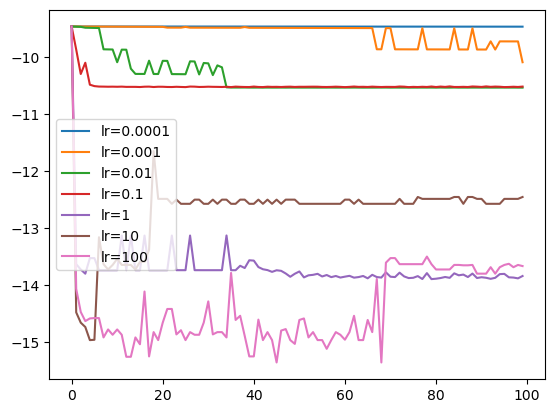

In [62]:
for lr in lrs:
    _ = plt.plot(lrs_timeline[lr], label=f'lr={lr}')
plt.legend()

In [63]:
from scipy import stats

In [64]:
#percentile of each best logP
for lr, exp in zip(lrs, exploration_index):
    print(f'Percentile of best score for lr={lr}: {stats.percentileofscore(target, np.min(lrs_timeline[lr]))} with {exp} samples')

Percentile of best score for lr=0.0001: 86.3120189009984 with 5 samples
Percentile of best score for lr=0.001: 77.85991921347458 with 8 samples
Percentile of best score for lr=0.01: 70.16233518786677 with 13 samples
Percentile of best score for lr=0.1: 70.16233518786677 with 13 samples
Percentile of best score for lr=1: 1.295632954805274 with 58 samples
Percentile of best score for lr=10: 0.09145644386860757 with 117 samples
Percentile of best score for lr=100: 0.038106851611919824 with 118 samples


In [65]:
# calcuate probability of each best logP is sampled from target distribution
for lr, exp in zip(lrs, exploration_index):
    samples = np.random.choice(target, exp)
    if exp == 0:
        print(f'Probability of best score for lr={lr}: 0 with {exp} samples')
    else:
        print(f'Probability of best score for lr={lr}: {np.sum(samples < np.min(lrs_timeline[lr])) / exp} with {exp} samples')


Probability of best score for lr=0.0001: 0.8 with 5 samples
Probability of best score for lr=0.001: 0.625 with 8 samples
Probability of best score for lr=0.01: 0.7692307692307693 with 13 samples
Probability of best score for lr=0.1: 0.7692307692307693 with 13 samples
Probability of best score for lr=1: 0.0 with 58 samples
Probability of best score for lr=10: 0.0 with 117 samples
Probability of best score for lr=100: 0.0 with 118 samples


In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(space.mol2vec)

PCA(n_components=2)

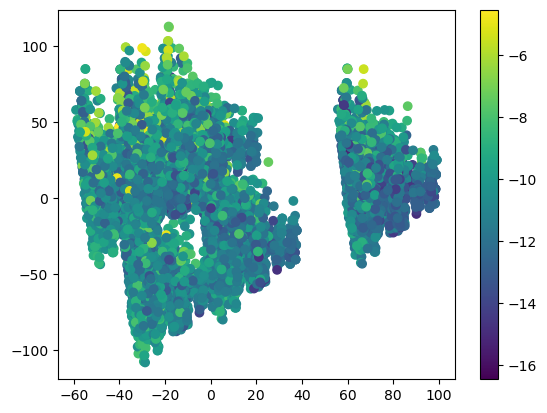

In [67]:
# plot PCA of mol2vec, use target as color
_ = plt.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target, cmap='viridis')
plt.colorbar()

In [87]:
# test evrything with lr 10
global_seed(676550)
X = torch.randn(300, requires_grad=True, dtype=torch.float64)
optimizer = Adam([X], lr=10)
CALLS = []
history = np.zeros(2000)

Global seed set to 676550


In [88]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(2000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -9.45860809163802, neighbors: [[ 1528 12732  9976   737  7276]]
Iteration 100: -14.48006323679859, neighbors: [[10982  6339 12396  2427  9086]]
Iteration 200: -14.660522764328439, neighbors: [[12396  3353 10982  9086  1684]]
Iteration 300: -14.860362171701713, neighbors: [[3353 5719 7234 8793 1684]]
Iteration 400: -14.974026259142823, neighbors: [[3353 8793 4183 2398 2239]]
Iteration 500: -14.616014575473658, neighbors: [[3353 8793 4183  616 2344]]
Iteration 600: -15.260316150587126, neighbors: [[3353 8793 9521 2398 9582]]
Iteration 700: -14.922275474636468, neighbors: [[3353 8793 9521 9582 1684]]
Iteration 800: -14.613453733275746, neighbors: [[ 5101 12994  2395  7230 10288]]
Iteration 900: -14.974175125985047, neighbors: [[3353 4183 2398 8793 1684]]
Iteration 1000: -14.893706994387534, neighbors: [[9521 3353 4183 2398 1684]]
Iteration 1100: -14.947805402977696, neighbors: [[ 3353  8793  4183 12396  2239]]
Iteration 1200: -15.434012458245777, neighbors: [[3353 8793 4183 9

In [89]:
space.get_neighbors(X.detach().numpy())
for i in space.get_neighbors(X.detach().numpy())[0]:
    print(space.get_objective(i))

-13.266666666666666
-13.066666666666668
-12.733333333333334
-13.066666666666668
-13.033333333333331


In [90]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 166 unique compounds
Best score: -15.434370830337974
Percentile: 0.038106851611919824
Best f(X): -15.095870522285889


In [91]:
space.f(best_X)

tensor(-15.0959, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [92]:
np.sum(target < best)

5

In [93]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-15.7
-15.833333333333334
-15.466666666666669
-14.966666666666669
-13.5


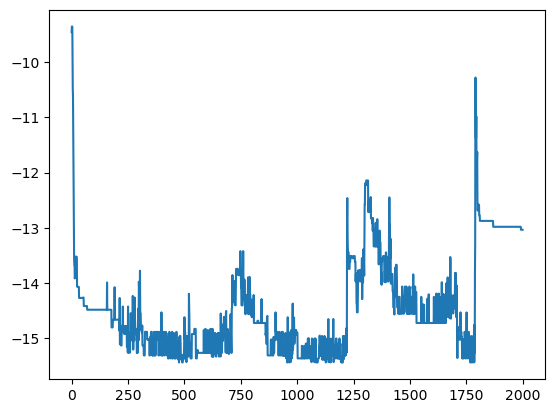

In [94]:
_ = plt.plot(history)

In [95]:
best_X

tensor([ 1.0097e+01, -4.3241e+01, -4.7225e+00,  4.8125e+01, -4.9733e+01,
        -2.1513e+01, -1.7096e+01,  1.9416e+01,  4.6394e+01,  3.1408e+01,
        -1.3980e+01, -1.8765e+01, -5.8708e+01,  1.6271e-01, -3.3616e+01,
        -1.7577e+01, -2.8723e+01,  2.5689e+01, -6.1663e+01, -3.4293e+00,
         2.6789e+01,  5.3758e+01,  3.3064e+01,  2.9760e+01, -3.6575e+01,
         1.2862e+01,  4.7707e+00, -5.0438e+01, -3.1255e+01,  1.6873e+01,
         6.2954e+01, -2.9101e+01, -1.6780e+01, -1.8686e+01,  1.7007e+01,
         1.1175e+01,  4.0792e+01, -3.6698e+01,  3.7087e+01,  1.4089e+01,
        -3.2490e+01, -2.3605e+01, -3.7904e+01,  1.0511e+01, -5.9022e+01,
         4.7704e+01, -1.6234e+01,  1.8570e+01, -3.5829e+01,  1.7930e+01,
         3.0979e+01, -1.6101e+01, -3.6370e+01, -5.7608e+01, -6.5171e+00,
         1.7525e+01, -9.7342e+00,  1.2464e+01,  4.0565e+01,  2.5647e+01,
         1.7609e+00, -5.0090e+01,  3.6513e+00,  8.0234e+00,  1.8874e+00,
         7.3414e+00,  5.8077e+01, -1.0824e+01,  3.0

In [96]:
space.f(best_X)

tensor(-15.0959, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [97]:
space.get_neighbors(best_X)

array([[3353, 8793, 4183, 9582, 1684]])

In [98]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-15.7
-15.833333333333334
-15.466666666666669
-14.966666666666669
-13.5


In [101]:
space.mol2vec.shape

(13121, 300)

In [114]:
def create_distribs(mol2vec):
    means = np.ones(mol2vec.shape[1])
    stds = np.ones(mol2vec.shape[1])
    for i in range(mol2vec.shape[1]):
        means[i] = np.mean(mol2vec[:, i])
        stds[i] = np.std(mol2vec[:, i])
    return means, stds

In [115]:
means, stds = create_distribs(space.mol2vec)

In [117]:
def sample_from_distribs(means, stds):
    return np.random.normal(means, stds)

In [121]:
sample_from_distribs(means, stds)

array([ 8.72736252e+00, -1.57638136e+01, -1.60583969e+01,  1.68797261e+01,
       -4.00734060e+00,  2.35988606e-01, -3.51005771e+01,  2.58623849e+00,
        3.21844860e+01,  1.56168490e+01, -1.09314247e+01, -2.52166716e+00,
       -3.14620606e+01,  3.83873958e+00, -1.68692776e+01, -1.22991474e+01,
        1.85598662e+01, -1.65379581e+01, -1.26982432e+01,  2.49474459e+01,
        1.55028122e+01,  2.24004075e+01,  5.37092996e+01,  2.88310453e+01,
       -4.22631175e+01, -3.96954675e+00, -2.13373269e+00, -2.75202959e+01,
       -2.31190848e+00, -5.42809266e-01,  4.73535175e+01, -1.97693829e+01,
       -1.84760289e+01, -2.02903404e+01,  2.10268503e+01,  6.65107523e+00,
       -5.28250528e+00, -4.80256268e+00,  4.04221458e+01,  8.53391456e+00,
       -5.60185519e+00, -7.82553044e+00, -1.08249186e+01, -5.60929740e-01,
       -4.99448839e+01,  2.77338499e+01, -1.34061585e+00,  3.18580321e+01,
       -2.85432876e+01,  1.62216495e+01,  2.14630426e+01, -3.12983594e+01,
       -1.41652711e+01, -

In [134]:
global_seed(676550)
X = torch.tensor(sample_from_distribs(means, stds), requires_grad=True, dtype=torch.float64)
optimizer = Adam([X], lr=10)
CALLS = []
history = np.zeros(5000)
X_positions = np.zeros((5000, 300))

Global seed set to 676550


In [135]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(5000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    X_positions[i] = X.detach().numpy()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -11.453340199251421, neighbors: [[ 2262  2983  9039  4456 11458]]
Iteration 100: -13.280788306515378, neighbors: [[12831 10677  5110 11345 12694]]
Iteration 200: -15.360149896862806, neighbors: [[3353 9521 8793 2398 4183]]
Iteration 300: -14.996169862191106, neighbors: [[3353 8793 9521 1684 9582]]
Iteration 400: -12.413387200903044, neighbors: [[10050 12273 12817  2462  8244]]
Iteration 500: -12.406735673847688, neighbors: [[10050 12273 12817  2462  8244]]
Iteration 600: -12.413406850475148, neighbors: [[10050 12273 12817  2462  8244]]
Iteration 700: -12.406758770633054, neighbors: [[10050 12273 12817  2462  8244]]
Iteration 800: -12.406773641301584, neighbors: [[10050 12273 12817  2462  7571]]
Iteration 900: -12.466729183590617, neighbors: [[12273 10050  2462  6844 12817]]
Iteration 1000: -12.466741905636527, neighbors: [[12273 10050  2462  6844 12817]]
Iteration 1100: -12.46675175833938, neighbors: [[12273 10050  2462  6844 12817]]
Iteration 1200: -12.493385934622983, ne

In [136]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 238 unique compounds
Best score: -15.360231070485764
Percentile: 0.038106851611919824
Best f(X): -14.96089534144426


In [137]:
X_positions[0]

array([ -5.4834098 ,  -1.13637142, -31.69817772,  12.12463365,
         3.36303213,  -8.137281  , -48.30439826,  -8.47859404,
        45.02992219,   8.069358  , -25.07061435,   7.91577488,
       -43.29999823,  -6.14103305, -12.37645192, -13.1282432 ,
        18.8300794 , -28.43723106, -27.34949782,  18.06934797,
        20.94698687,   7.62633054,  45.82058081,  14.31378648,
       -30.38633359,  13.88855808,   6.82051099, -31.13355759,
        11.35691187,  -9.39240274,  51.53790464, -19.84872793,
        -0.60119034, -10.87297172,   2.81707141,  14.4887096 ,
        11.3514309 ,  15.54844349,  23.16249688,  -3.98101588,
         4.98482328, -15.48737078, -20.03738541,  -8.29505245,
       -39.34339629,  16.22696882,  -7.00073654,  13.62416065,
       -11.20403506,  -8.64517155,   7.42795561, -10.33275031,
        -1.48865416, -17.455918  , -14.17726921, -28.41669401,
       -22.2410805 ,  17.54048694,  -2.20400585,   6.62712672,
         7.50855164, -17.84189663,   1.89297087,   1.32

In [138]:
X_positions_pca = pca.transform(X_positions)

In [140]:
# make animated plot of optimization with X positions moving over all compounds
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

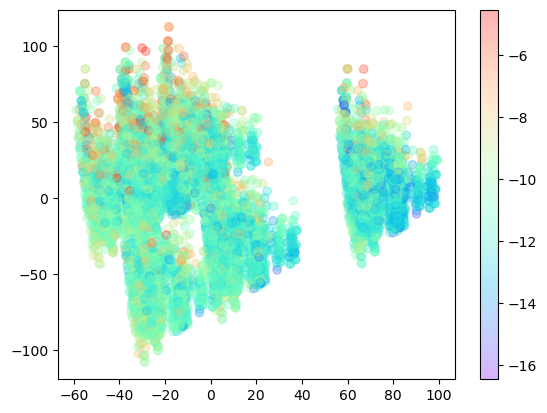

In [155]:
# plot PCA of mol2vec, use target counter as color
_ = plt.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target, cmap='rainbow', alpha=0.3)
_ = plt.colorbar()

In [173]:
!mkdir images

In [169]:
x_scores = [space.f(torch.tensor(X_positions[i], dtype=torch.float64)) for i in range(2000)]

/tmp/ipykernel_4492/696106937.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'images/{i}.png'))
/tmp/ipykernel_4492/696106937.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'images/{i}.png'))
/tmp/ipykernel_4492/696106937.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'images/

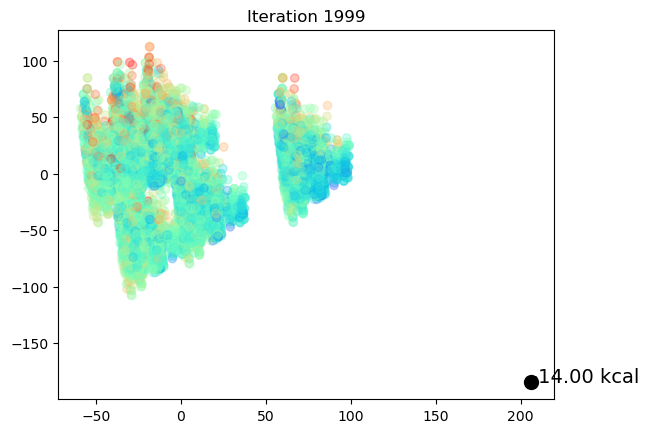

In [174]:
import imageio
images = []
for i in range(0, 2000, 1):
    plt.clf()
    plt.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target, cmap='rainbow', alpha=0.3)
    plt.scatter(X_positions_pca[i, 0], X_positions_pca[i, 1], c='black', s=100)
    plt.text(X_positions_pca[i, 0], X_positions_pca[i, 1], f'{x_scores[i]:.2f} kcal', fontsize=14)
    plt.title(f'Iteration {i}')
    plt.savefig(f'images/{i}.png')
    images.append(imageio.imread(f'images/{i}.png'))

In [181]:
# save as video
imageio.mimsave('movie.mp4', images)